### Discretization

One of the benchmark algorithms - SimOOS from "Data-Driven Online Recommender Systems With Costly Information Acquisition" works by enumerating all possible states. For it to work correctly each dimension of context vectors should have only a finite number of values in the whole dataset.

In this notebook I want to see what happens if I discretize the context vectors, that is, I fix the number of values and round the values of context vectors to the closes possible value.

## Preliminary results:

After discretization old algorithms still perform quite okay, so it might be a valid way to proceed.
Another reason why this preprocessing is valid is that features in R6A represent proximity to user cluster centroids. So discretizing them just maps the real proximity with several discrete proximity values, which are still informative.

SimOOS performs badly on this data. 
Testing Algorithm1 is impossible, as it just takes too much time.

In [1]:
import os
os.chdir('../..')
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings

import algorithms
import costs
import evaluation
import dataset

In [3]:
%%time
import gc

FILENAME = "dataset/R6/subsample/data_04_medium_large.pickle"


with open(FILENAME, "rb") as f:
    gc.disable()
    data = pickle.load(f)
    gc.enable()
    


CPU times: user 401 ms, sys: 141 ms, total: 542 ms
Wall time: 1.01 s


## Experiment parameters

In [4]:
NUM_BINS = 4

### Preprocess data

In [5]:
X = np.stack(
 [
     ev.user_features for ev in data.events
 ]
)


In [6]:
column = 4
np.unique(X[:, column]).shape

(125798,)

In [7]:
def discretize(array, num_bins):
    x_min = min(array)
    x_max = max(array)
    bins = np.linspace(x_min, x_max, num_bins+1)
    new_array = array.copy()
    for i in range(len(array)):
        x = array[i]
        if x >= x_max:
            new_x = x_max
        elif x <= x_min:
            new_x = x_min
        else:
            new_x = bins[np.digitize(x, bins)]
        new_array[i] = new_x
    return new_array

In [8]:
def discretize_with_index(array, num_bins):
    x_min = min(array)
    x_max = max(array)
    bins = np.linspace(x_min, x_max, num_bins+1)
    new_array = array.copy()
    for i in range(len(array)):
        x = array[i]
        if x >= x_max:
            new_x = num_bins
        elif x <= x_min:
            new_x = 1
        else:
            new_x = np.digitize(x, bins)
        new_array[i] = new_x
    return new_array

In [9]:
# Example
discretize([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.9, 0.8, 0.7, 0.6, 1], 4)

[0, 0.25, 0.25, 0.5, 0.5, 0.75, 1.0, 1.0, 0.75, 0.75, 1]

In [10]:
# Example
discretize_with_index([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.9, 0.8, 0.7, 0.6, 1], 4)

[1, 1, 1, 2, 2, 3, 4, 4, 3, 3, 4]

In [11]:
X.shape

(600000, 6)

In [12]:
X[:5, :]

array([[9.85230e-02, 6.92600e-03, 1.14530e-02, 6.63200e-02, 8.16778e-01,
        1.00000e+00],
       [4.42000e-04, 8.00000e-06, 1.68000e-04, 4.66000e-04, 9.98916e-01,
        1.00000e+00],
       [6.90000e-05, 2.00000e-06, 9.00000e-06, 4.30000e-05, 9.99876e-01,
        1.00000e+00],
       [4.79541e-01, 1.37040e-01, 4.47990e-02, 3.37886e-01, 7.35000e-04,
        1.00000e+00],
       [6.53461e-01, 1.62730e-02, 1.55137e-01, 1.73519e-01, 1.61000e-03,
        1.00000e+00]])

In [13]:
X_disc = np.ones(X.shape, dtype=np.single)

### Discretize each feature into NUM_BINS unique values 

In [14]:
%%time

for column in range(6):
    X_disc[:, column] = discretize(X[:, column], NUM_BINS)

CPU times: user 7 s, sys: 140 ms, total: 7.14 s
Wall time: 7.14 s


In [15]:
X_disc

array([[0.24202025, 0.24999075, 0.249996  , 0.24933375, 1.        ,
        1.        ],
       [0.24202025, 0.24999075, 0.249996  , 0.24933375, 1.        ,
        1.        ],
       [0.24202025, 0.24999075, 0.249996  , 0.24933375, 1.        ,
        1.        ],
       ...,
       [0.24202025, 0.24999075, 0.999984  , 0.24933375, 0.25      ,
        1.        ],
       [0.24202025, 0.24999075, 0.249996  , 0.997335  , 0.25      ,
        1.        ],
       [0.4840405 , 0.24999075, 0.499992  , 0.24933375, 0.25      ,
        1.        ]], dtype=float32)

In [16]:
X_disc[:, 0]

array([0.24202025, 0.24202025, 0.24202025, ..., 0.24202025, 0.24202025,
       0.4840405 ], dtype=float32)

In [17]:
for event, x in zip(data.events,X_disc):
    event.user_features = x

In [18]:
a = np.stack([ev.user_features for ev in data.events[:10]])

In [19]:
np.unique(a, axis=0)

array([[0.24202025, 0.24999075, 0.249996  , 0.24933375, 1.        ,
        1.        ],
       [0.24202025, 0.24999075, 0.999984  , 0.24933375, 0.25      ,
        1.        ],
       [0.4840405 , 0.24999075, 0.249996  , 0.4986675 , 0.25      ,
        1.        ],
       [0.72606075, 0.24999075, 0.249996  , 0.24933375, 0.25      ,
        1.        ],
       [0.72606075, 0.24999075, 0.249996  , 0.4986675 , 0.25      ,
        1.        ]], dtype=float32)

## Evaluate on preprocessed data

In [20]:
NUM_OF_TRIALS = 40000

In [21]:
p_random = algorithms.RandomPolicy()
ctr_random = evaluation.evaluate(p_random, data, stop_after=NUM_OF_TRIALS)

Random policy with ZeroCosts
Average reward: 0.0251
Execution time: 2.2s


In [22]:
ucb_alg = algorithms.UCB1(
        n_trials=NUM_OF_TRIALS,
        n_arms=data.n_arms,
        alpha=0.01,
    )
ctr_ucb = evaluation.evaluate(ucb_alg, data, stop_after=NUM_OF_TRIALS)

UCB1 (α=0.01) with ZeroCosts
Average reward: 0.0365
Execution time: 4.3s


In [23]:
linucb = algorithms.LinUCB(
    n_trials=NUM_OF_TRIALS,
    context_dimension=len(data.events[0].user_features),
    n_arms=data.n_arms,
    alpha=0.3,
)
ctr_linucb = evaluation.evaluate(linucb, data, stop_after=NUM_OF_TRIALS)

LinUCB (alpha=0.3) with ZeroCosts
Average reward: 0.0376
Execution time: 10.4s


In [24]:
ps_linucb = algorithms.PSLinUCB(
    n_trials=NUM_OF_TRIALS,
    context_dimension=len(data.events[0].user_features),
    n_arms=data.n_arms,
    alpha=0.25,
    omega=6000,
    delta=0.04
)
ctr_pslinucb = evaluation.evaluate(ps_linucb, data, stop_after=NUM_OF_TRIALS)
change_points = ps_linucb.change_points

PSLinUCB (alpha=0.25, omega=6000, delta=0.04) with ZeroCosts
Average reward: 0.0381
Execution time: 11.3s


In [25]:
# s = time.time()
# p_simoos = algorithms.SimOOSAlgorithm(
#     all_contexts=X_disc[:, :], 
#     number_of_actions=data.n_arms,
#     max_no_red_context=len(data.events[0].user_features),
#     beta_SimOOS=0.6,
#     delta_SimOOS=0.2,
# )
# print(f"Took {time.time() - s} seconds")


# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     s = time.time()
#     ctr_simoos = evaluation.evaluate(
#         p_simoos,
#         data,
#         stop_after=NUM_OF_TRIALS,
#     )
#     print(f"Took {time.time() - s} seconds")


In [26]:
# del p_simoos
# gc.collect()

In [27]:
# s = time.time()
# p_alg1 = algorithms.Algorithm1(
#     all_contexts=X_disc[:, :], 
#     number_of_actions=data.n_arms,
#     max_no_red_context=len(data.events[0].user_features),
#     beta=1.0,
#     delta=0.12,
#     window_length=2000,
# )
# print(f"Took {time.time() - s} seconds")


# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     s = time.time()
#     ctr_alg1 = evaluation.evaluate(
#         p_alg1,
#         data,
#         stop_after=NUM_OF_TRIALS,
#     )
#     print(f"Took {time.time() - s} seconds")


In [28]:
np.unique(X_disc[:, 4], axis=0)

array([0.  , 0.25, 0.5 , 0.75, 1.  ], dtype=float32)

In [29]:
def plot_ctrs(ctr_dict, change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(16, 8));
    
    N = 40
    
    max_vline=0
    
    for label, ctr in ctr_dict.items():
        ax.plot(ctr[N:], label=label)
        max_vline=max(max_vline, max(ctr[N:]))
    ax.set_xlabel('Trial')
    ax.set_ylabel('CTR')
    ax.set_title('Evaluation without costs')
    
    ax.vlines(change_points, 0, max_vline, label='change points', color='pink')

    plt.legend();
    plt.show();

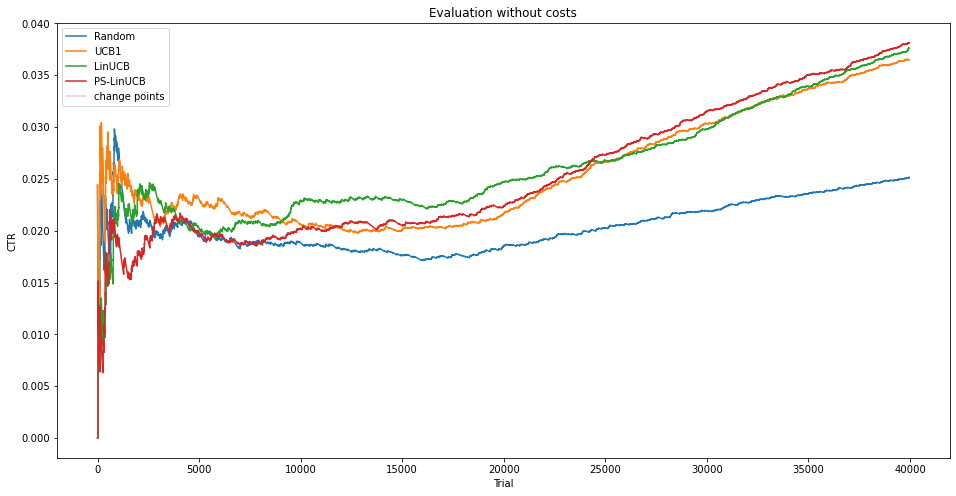

In [30]:
plot_ctrs(
    {
        'Random': ctr_random,
        'UCB1': ctr_ucb,
        'LinUCB': ctr_linucb,
        'PS-LinUCB': ctr_pslinucb,
#         'SimOOS': ctr_simoos,
#         'Alg1': ctr_alg1,
    },
)


## For comparison evaluate on original data

In [31]:
del data

with open(FILENAME, "rb") as f:
    gc.disable()
    original_data = pickle.load(f)
    gc.enable()

In [32]:
a = np.stack([ev.user_features for ev in original_data.events[:10]])

In [33]:
np.unique(a, axis=0)

array([[6.90000e-05, 2.00000e-06, 9.00000e-06, 4.30000e-05, 9.99876e-01,
        1.00000e+00],
       [4.42000e-04, 8.00000e-06, 1.68000e-04, 4.66000e-04, 9.98916e-01,
        1.00000e+00],
       [1.63400e-03, 1.00000e-06, 9.96804e-01, 1.56100e-03, 1.00000e-06,
        1.00000e+00],
       [1.04070e-02, 6.25100e-03, 2.30000e-05, 1.29800e-03, 9.82021e-01,
        1.00000e+00],
       [6.61410e-02, 2.93300e-03, 1.40700e-03, 5.84000e-03, 9.23679e-01,
        1.00000e+00],
       [9.85230e-02, 6.92600e-03, 1.14530e-02, 6.63200e-02, 8.16778e-01,
        1.00000e+00],
       [4.79541e-01, 1.37040e-01, 4.47990e-02, 3.37886e-01, 7.35000e-04,
        1.00000e+00],
       [5.53029e-01, 4.58770e-02, 9.41290e-02, 2.91508e-01, 1.54570e-02,
        1.00000e+00],
       [5.76717e-01, 8.98400e-03, 1.94949e-01, 2.05601e-01, 1.37490e-02,
        1.00000e+00],
       [6.53461e-01, 1.62730e-02, 1.55137e-01, 1.73519e-01, 1.61000e-03,
        1.00000e+00]])

In [34]:
p_random = algorithms.RandomPolicy()
ctr_random = evaluation.evaluate(p_random, original_data, stop_after=NUM_OF_TRIALS)

Random policy with ZeroCosts
Average reward: 0.0236
Execution time: 1.9s


In [35]:
ucb_alg = algorithms.UCB1(
        n_trials=NUM_OF_TRIALS,
        n_arms=original_data.n_arms,
        alpha=0.01,
    )
ctr_ucb = evaluation.evaluate(ucb_alg, original_data, stop_after=NUM_OF_TRIALS)

UCB1 (α=0.01) with ZeroCosts
Average reward: 0.0365
Execution time: 4.0s


In [36]:
linucb = algorithms.LinUCB(
    n_trials=NUM_OF_TRIALS,
    context_dimension=len(original_data.events[0].user_features),
    n_arms=original_data.n_arms,
    alpha=0.3,
)
ctr_linucb = evaluation.evaluate(linucb, original_data, stop_after=NUM_OF_TRIALS)

LinUCB (alpha=0.3) with ZeroCosts
Average reward: 0.0392
Execution time: 10.3s


In [37]:
ps_linucb = algorithms.PSLinUCB(
    n_trials=NUM_OF_TRIALS,
    context_dimension=len(original_data.events[0].user_features),
    n_arms=original_data.n_arms,
    alpha=0.25,
    omega=6000,
    delta=0.04
)
ctr_pslinucb = evaluation.evaluate(ps_linucb, original_data, stop_after=NUM_OF_TRIALS)
change_points = ps_linucb.change_points

PSLinUCB (alpha=0.25, omega=6000, delta=0.04) with ZeroCosts
Average reward: 0.0398
Execution time: 11.7s


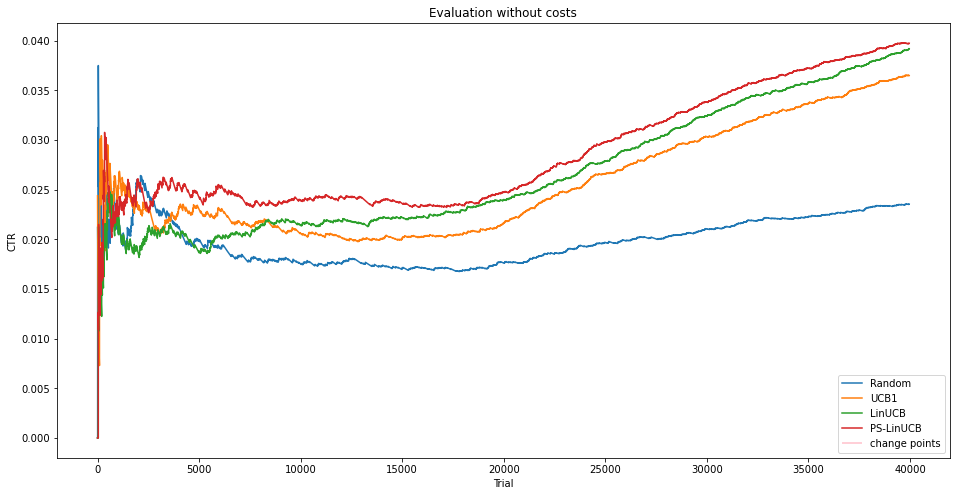

In [38]:
plot_ctrs(
    {
        'Random': ctr_random,
        'UCB1': ctr_ucb,
        'LinUCB': ctr_linucb,
        'PS-LinUCB': ctr_pslinucb,
    },
)
